In [183]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [184]:
TRAIN_DATA_PATH = './train.csv'
TEST_DATA_PATH = './test.csv'

origin_train = pd.read_csv(TRAIN_DATA_PATH)
origin_test = pd.read_csv(TEST_DATA_PATH)

In [185]:
features = origin_train.columns[2:]
target = pd.DataFrame(origin_train, columns=['target'])
df_train = pd.DataFrame(origin_train, columns=features)
df_test = pd.DataFrame(origin_test, columns=features)

In [186]:
"""
trainとtestの新しい特徴量を作る関数
feature_num = var_{feature_num}の特徴量を作る
"""

feature_num = 1

def new_feature(df_train, df_test, feature_num):   
    new_train = pd.DataFrame([])
    new_test = pd.DataFrame([])
    for i in range(0, 200):
        new_train[f'var_{feature_num}_{i}'] = df_train[f'var_{feature_num}'] + df_train[f'var_{i}']
        new_test[f'var_{feature_num}_{i}'] = df_test[f'var_{feature_num}'] + df_test[f'var_{i}']
    return new_train, new_test

In [187]:
"""
ストレージに余裕があればfeature_numをfor文で回して特徴量ごとのcsvファイル作ってあとでまとめて学習も有り
そのまま学習したければ下記の関数はコメントアウトして大丈夫
"""


# def new_feature_csv():
#     train_id = pd.DataFrame(origin_train['ID_code'])
#     test_id= pd.DataFrame(origin_test['ID_code'])
#     new_train, new_test = new_feature(df_train, df_test, feature_num)
#     new_train_df = pd.concat([train_id, target, new_train], axis=1)
#     new_test_df = pd.concat([test_id, new_test], axis=1)
#     new_train_df.to_csv(f'train_new_var_{feature_num}.csv', index=False)
#     new_test_df.to_csv(f'test_new_var_{feature_num}.csv', index=False)

'\nストレージに余裕があればfeature_numをfor文で回して特徴量ごとのcsvファイル作ってあとでまとめて学習も有り\nそのまま学習したければ下記の関数はコメントアウトして大丈夫\n'

In [189]:
"""
元のデータとスタックして学習させたいときはこの関数使う
スタックしないで学習するときはnew_featureの戻り値をtrain, testで受け取って学習させる
"""

def stack_data():
    new_train, new_test = new_feature(df_train, df_test, feature_num)
    train = pd.concat([df_train, new_train], axis=1)
    test = pd.concat([df_test, new_train], axis=1)
    return train, test

train, test = stack_data()

In [191]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [192]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89904	valid_1's auc: 0.880364
[2000]	training's auc: 0.911204	valid_1's auc: 0.888868
[3000]	training's auc: 0.91903	valid_1's auc: 0.893151
[4000]	training's auc: 0.924854	valid_1's auc: 0.896012
[5000]	training's auc: 0.929701	valid_1's auc: 0.897714
[6000]	training's auc: 0.933934	valid_1's auc: 0.898494
[7000]	training's auc: 0.93786	valid_1's auc: 0.898994
[8000]	training's auc: 0.941613	valid_1's auc: 0.89928
[9000]	training's auc: 0.945152	valid_1's auc: 0.899671
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.898872	valid_1's auc: 0.881324
[2000]	training's auc: 0.911092	valid_1's auc: 0.890141
[3000]	training's auc: 0.918887	valid_1's auc: 0.894037
[4000]	training's auc: 0.924

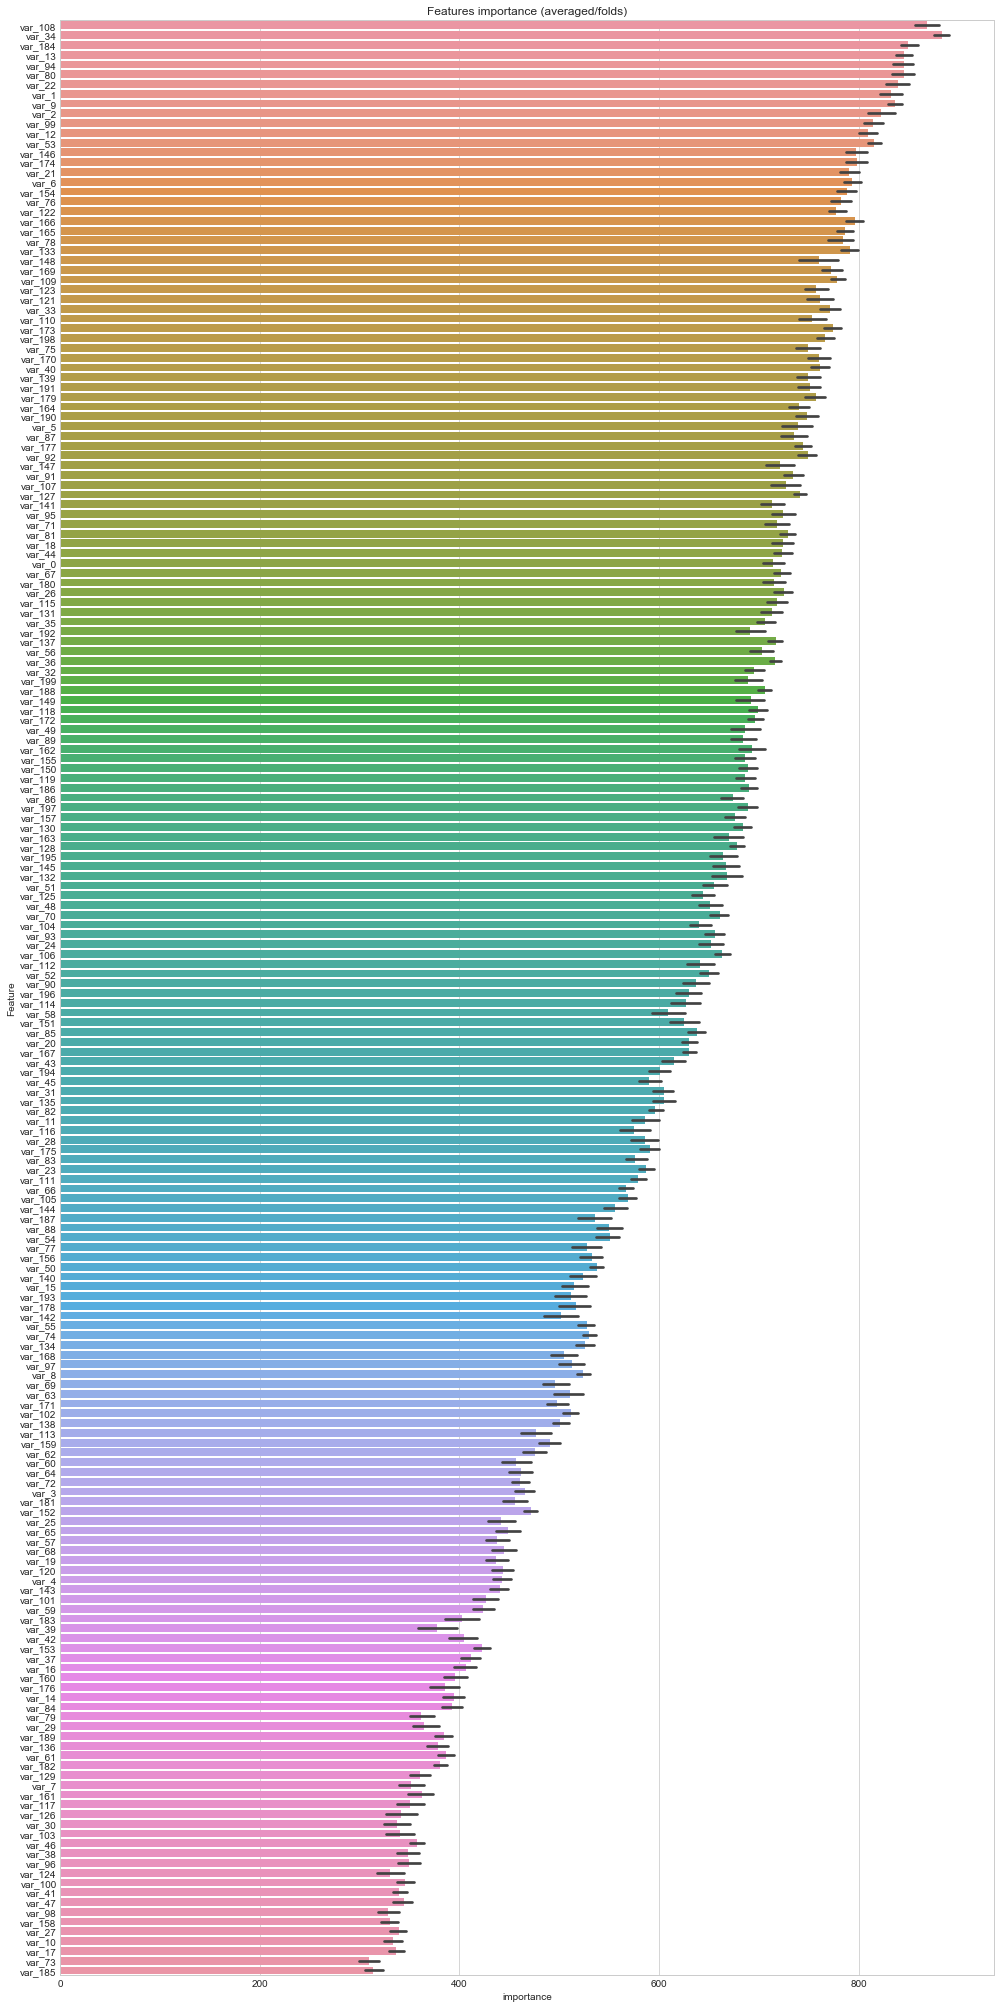

In [193]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:600].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [194]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": origin_test.ID_code.values})
sub["target"]=predictions
sub.to_csv(f"submission_new_var{feature_num}_{score}.csv", index=False)